In [62]:
## Uncomment these lines if running as a google colab notebook: 
##! git clone https://github.com/kundajelab/adar_editing
##import os
##os.chdir("adar_editing/xgboost_with_shap/")
##!pip install -e https://github.com/slundberg/shap
##!pip install --upgrade xgboost
##!pip install cufflinks

def enable_plotly_in_cell():
  import IPython
  from plotly.offline import init_notebook_mode
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
  '''))
%load_ext autoreload
%autoreload 2   

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [63]:
#helper utilities for model training and interpretation 
from helpers import * 

#set a random seed so code is reproducible 
random.seed(1234)

# load JS visualization code to notebook
shap.initjs()
import warnings
warnings.filterwarnings('ignore')

#visualization utilities 
import matplotlib
import matplotlib.pyplot as plt 
%matplotlib inline
import plotly.plotly as py
import numpy as np
from plotly.offline import iplot
from plotly.graph_objs import Heatmap

#init_notebook_mode(connected=False)



## Neil1 xgboost with TreeShap <a name='outline'>
<ol>
    <li><a href=#1>Degenerate Dataset</a></li>
    <li><a href=#2>Degenerate Dataset: Feature Subsets</a></li>
    <li><a href=#3>Computational Dataset</a></li>
    <li><a href=#4>Computational Dataset Feature Subsets</a></li>
 </ol>


## NEIL1 Degenerate features<a name='1'>
<a href=#outline>Home</a>

In [64]:
## Read in the data 
import pandas as pd 
data=pd.read_csv("../xin_feature_matrices/neil1_degenerate_computational.features.csv.cleaned",header=0,sep='\t',index_col=0)

In [65]:
#remove any null editing level values 
data=data[~data["editing_value"].isnull().values]

In [66]:
## prepare data for training with xgboost 
data=format_for_xgboost(data)
train_split,eval_split,test_split=split_train_test_eval_by_mut_pos(data)

(855, 183)
{44: 98, 45: 155, 46: 124, 48: 160, 49: 79, 50: 97, 51: 12, 52: 12, 53: 10, 54: 108}


In [67]:
#Remove any non-varying features 
train_novar=get_singleval_features(train_split)
eval_novar=get_singleval_features(eval_split)
test_novar=get_singleval_features(test_split)
uniform_features_to_drop=list(set(train_novar+eval_novar+test_novar))

In [68]:
#Remove any null features 
train_null=get_all_null_features(train_split)
eval_null=get_all_null_features(eval_split)
test_null=get_all_null_features(test_split)
null_features_to_drop=list(set(train_null+eval_null+test_null))

In [69]:
to_drop=list(set(uniform_features_to_drop+null_features_to_drop))
print("\n".join(to_drop))

d1_length_hairpin
d2_length_hairpin
d3_exist
u3_5prm_cp_interior
mut_ref_nt:G
d2_3prm_cp_interior:G:U
mut_prev_struct:B
d2_3prm_cp_bulge:G:C
mut_ref_nt:A
d2_5prm_cp_bulge:G:U
d1_exist
mut_nt:G
d2_5prm_cp_bulge:C:G
u1_length_interior_ecs
u3_length_interior_es
u2_3prm_cp_interior
u3_3prm_cp_interior
u2_5prm_cp_interior
u2_5prm_cp_hairpin:U:G
mut_exist
mut_ref_nt:C
d2_3prm_cp_interior:A:U
d3_length_hairpin
d2_5prm_cp_hairpin
u1_exist
u2_5prm_cp_bulge:U:A
u3_3prm_cp_bulge:U:A
d2_exist
u1_5prm_cp_hairpin:C:G
d2_3prm_cp_bulge:G:U
u1_length_interior_es
site_5prm_cp_bulge:G:U
u3_length_interior_ecs
u1_5prm_cp_interior
u2_length_interior_es
u1_3prm_cp_interior
mut_ref_nt:U
u2_5prm_cp_bulge:G:U
mut_pos
u2_length_interior_ecs
d1_5prm_cp_hairpin
mut_site_dist
mut_type:mismatch
mut_next_struct:H
d3_5prm_cp_hairpin


In [70]:
train_split=train_split.drop(to_drop,axis=1)
eval_split=eval_split.drop(to_drop,axis=1)
test_split=test_split.drop(to_drop,axis=1)

In [71]:
train_y=train_split['editing_value']
train_X=train_split.drop(['editing_value'],axis=1)

eval_y=eval_split['editing_value']
eval_X=eval_split.drop(['editing_value'],axis=1)

test_y=test_split['editing_value']
test_X=test_split.drop(['editing_value'],axis=1)

In [72]:
print(train_X.shape)
print(train_y.shape)
print(eval_X.shape)
print(eval_y.shape)
print(test_X.shape)
print(test_y.shape)


(494, 137)
(494,)
(98, 137)
(98,)
(167, 137)
(167,)


In [73]:
## format matrixes for xgboost 
dtrain=xgboost.DMatrix(train_X,train_y)
deval=xgboost.DMatrix(eval_X,eval_y)
dtest=xgboost.DMatrix(test_X,test_y)

In [74]:
## set model training parameters 
param=dict() 
param['nthread'] = 20
#rmse -- root mean square error 
# mae -- mean absolute error 
# map -- mean average precision 
# auc -- area under ROC curve 
# aucpr -- area under precision recall curve 
param['eval_metric'] = ['auc','mae','map','aucpr','rmse']

In [75]:
evallist = [(deval, 'eval'), (dtrain, 'train')]


In [76]:
num_round = 1000
bst = xgboost.train(param, dtrain, num_round, evallist,early_stopping_rounds=10)

[18:15:27] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=6
[0]	eval-auc:0.950346	eval-mae:0.335107	eval-map:1	eval-aucpr:0.562985	eval-rmse:0.339925	train-auc:0.967409	train-mae:0.320991	train-map:1	train-aucpr:0.712417	train-rmse:0.329883
Multiple eval metrics have been passed: 'train-rmse' will be used for early stopping.

Will train until train-rmse hasn't improved in 10 rounds.
[18:15:27] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=6
[1]	eval-auc:0.950346	eval-mae:0.23595	eval-map:1	eval-aucpr:0.562985	eval-rmse:0.239	train-auc:0.96838	train-mae:0.229097	train-map:1	train-aucpr:0.734017	train-rmse:0.23545
[18:15:27] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=6
[2]	eval-auc:0.950468	eval-mae:0.166148	eval-map:1	eval-aucpr:0.566725	eval-rmse:0.168593	train-auc:0.968315	train-mae:0.164344	tr

[18:15:27] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=6
[27]	eval-auc:0.974214	eval-mae:0.009731	eval-map:1	eval-aucpr:0.576212	eval-rmse:0.031581	train-auc:0.974335	train-mae:0.011705	train-map:1	train-aucpr:0.748366	train-rmse:0.048177
[18:15:27] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=6
[28]	eval-auc:0.974	eval-mae:0.009947	eval-map:1	eval-aucpr:0.576138	eval-rmse:0.031628	train-auc:0.974359	train-mae:0.011652	train-map:1	train-aucpr:0.748395	train-rmse:0.04815
[18:15:27] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=6
[29]	eval-auc:0.974051	eval-mae:0.009864	eval-map:1	eval-aucpr:0.576176	eval-rmse:0.031565	train-auc:0.974392	train-mae:0.011559	train-map:1	train-aucpr:0.748418	train-rmse:0.048101
[18:15:27] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra n

[18:15:27] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[54]	eval-auc:0.975098	eval-mae:0.010152	eval-map:1	eval-aucpr:0.576461	eval-rmse:0.031653	train-auc:0.974706	train-mae:0.010861	train-map:1	train-aucpr:0.749111	train-rmse:0.047922
[18:15:27] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[55]	eval-auc:0.975098	eval-mae:0.010152	eval-map:1	eval-aucpr:0.576461	eval-rmse:0.031653	train-auc:0.974706	train-mae:0.010861	train-map:1	train-aucpr:0.749111	train-rmse:0.047922
[18:15:27] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[56]	eval-auc:0.975098	eval-mae:0.010152	eval-map:1	eval-aucpr:0.576461	eval-rmse:0.031653	train-auc:0.974706	train-mae:0.010861	train-map:1	train-aucpr:0.749111	train-rmse:0.047922
[18:15:27] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra n

In [77]:
# save to binary file for faster loading
bst.save_model('neil1.degenerate.model')
# save model to text file 
bst.dump_model('neil1.degenerate.raw.txt')


In [78]:
## get model predictions on the test split 
test_pred = bst.predict(dtest)

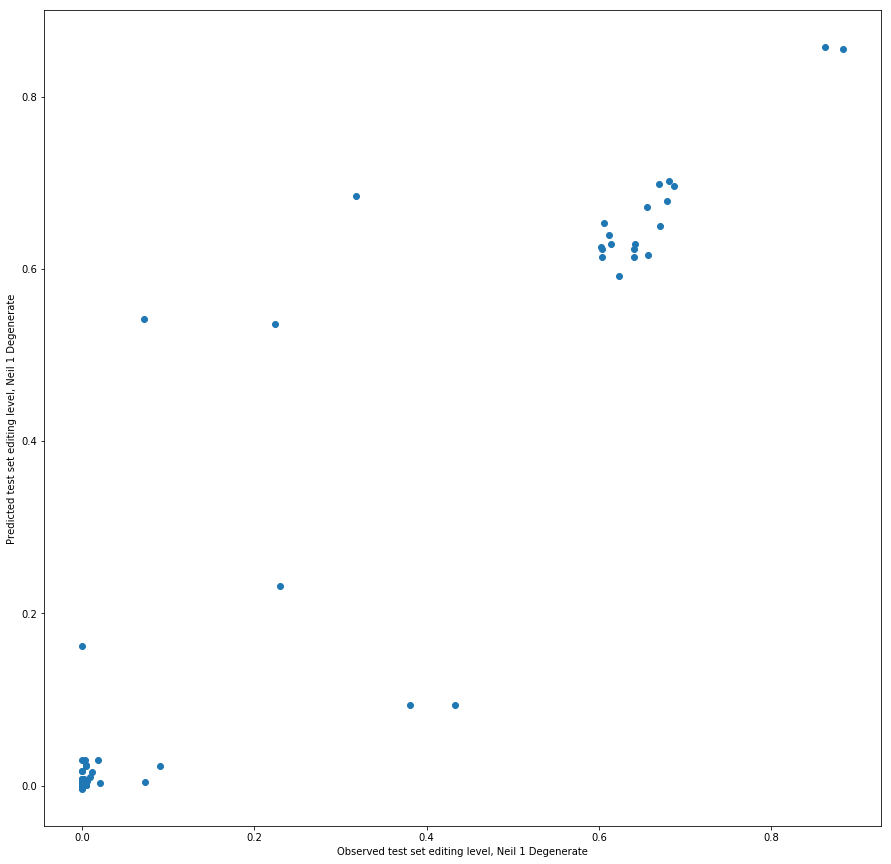

In [79]:
#plot the test set predictions 

matplotlib.rcParams['figure.figsize'] = [15, 15]
test_y=list(test_y)
test_pred=list(test_pred)
#fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(test_y,test_pred,'o')
plt.xlabel("Observed test set editing level, Neil 1 Degenerate")
plt.ylabel("Predicted test set editing level, Neil 1 Degenerate")
plt.show()

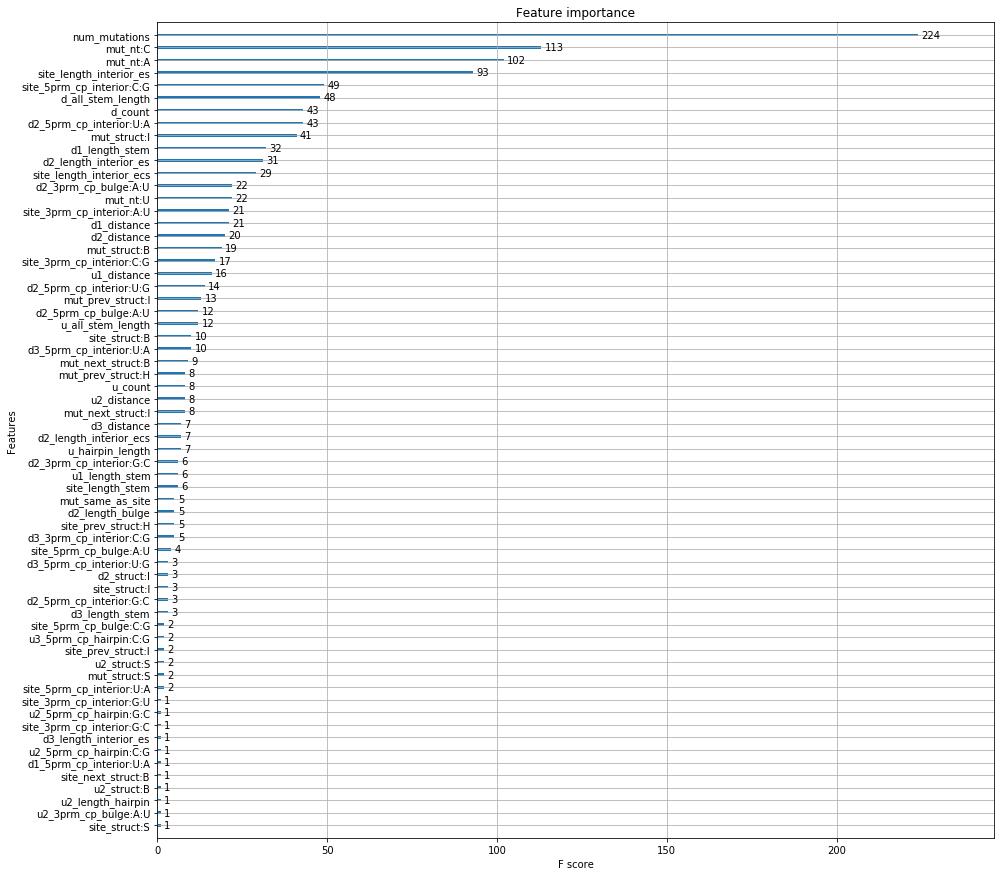

In [80]:
xgboost.plot_importance(bst)

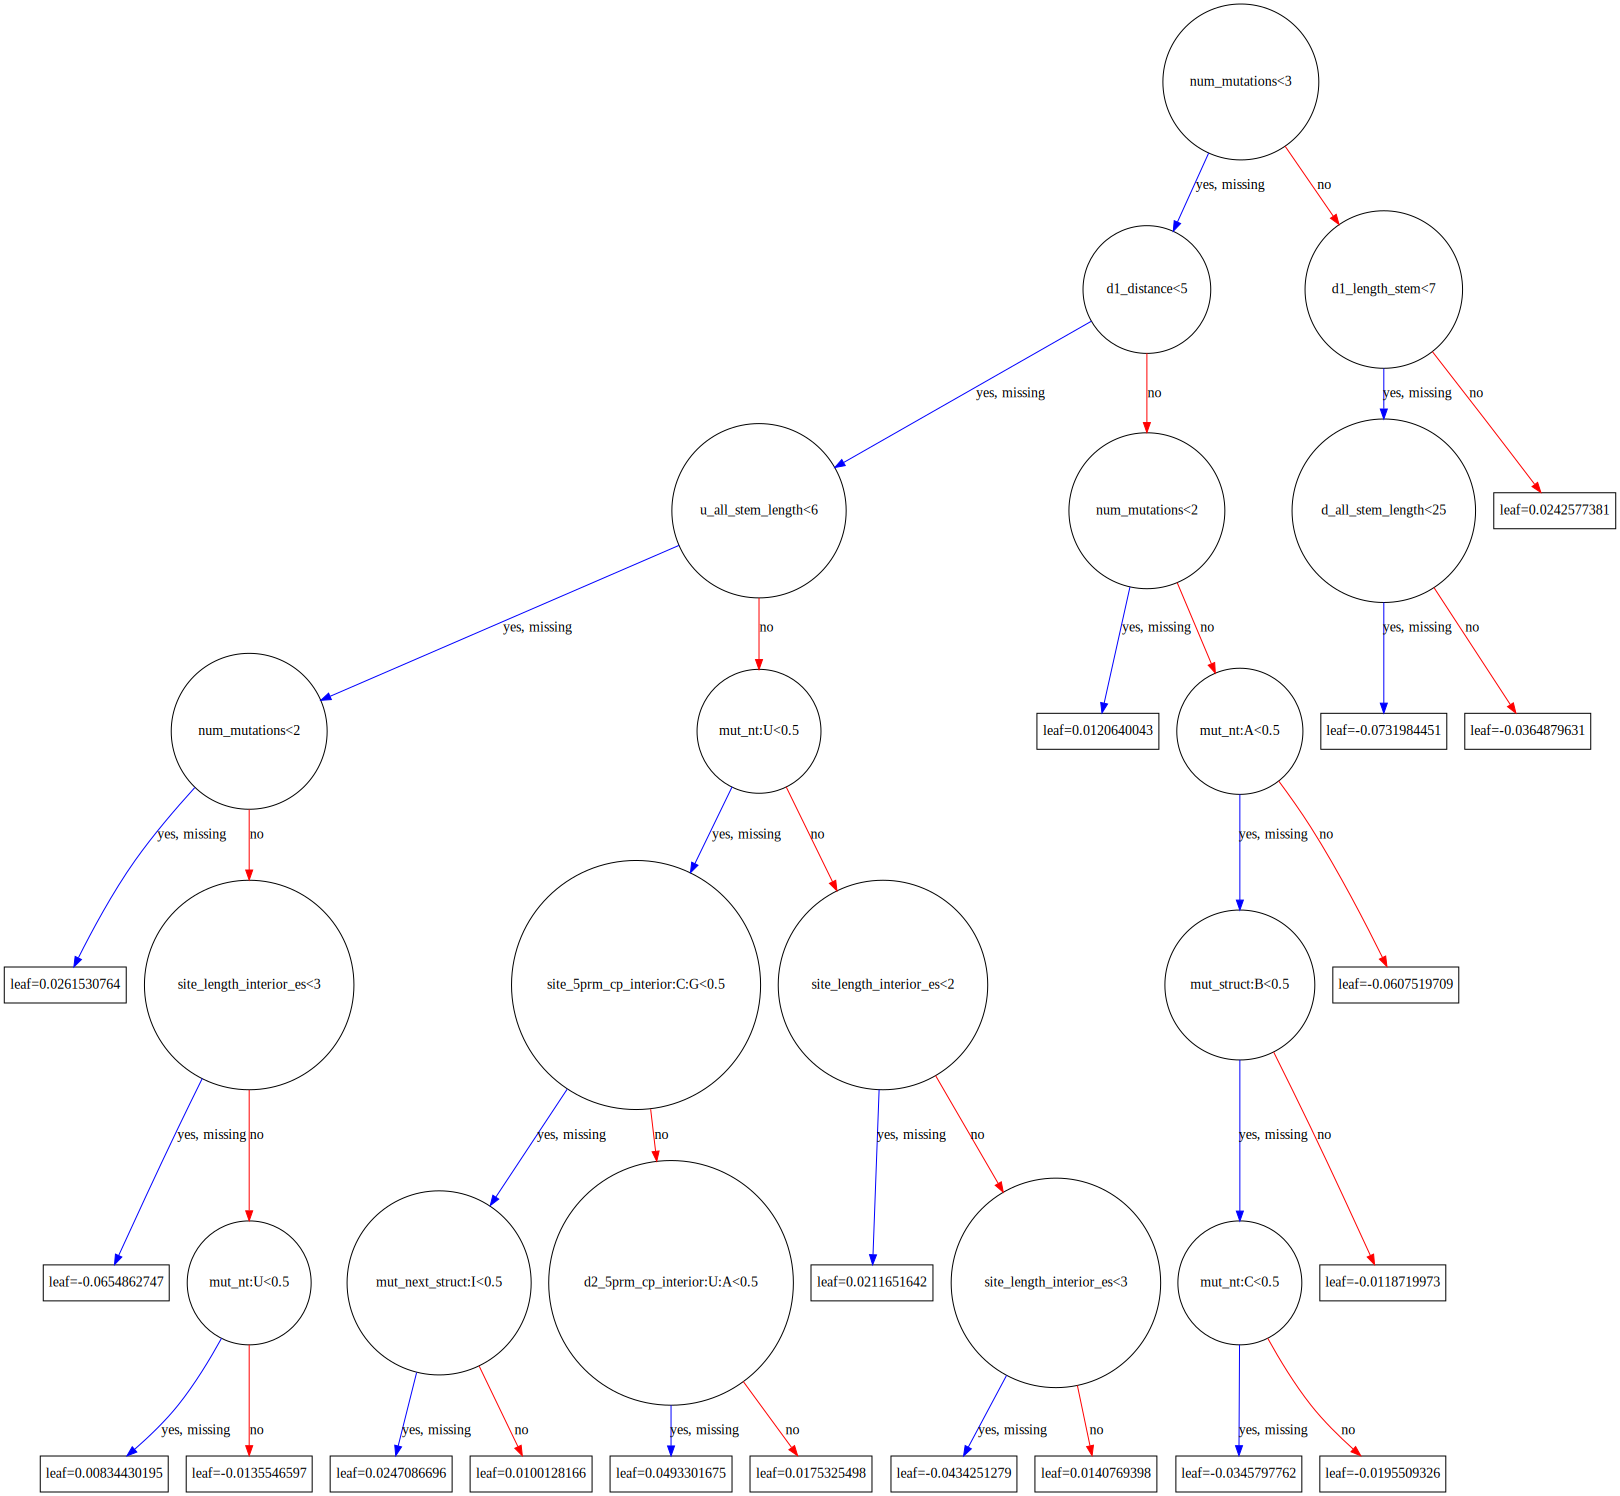

In [81]:
xgboost.to_graphviz(bst, num_trees=2)


In [82]:
# explain the model's predictions using SHAP values
explainer = shap.TreeExplainer(bst)
shap_values = explainer.shap_values(test_X)


In [83]:
shap_values.shape

(167, 137)

In [84]:
# visualize prediction for isoform with the highest editing level 
max_index=test_y.index(max(test_y))
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[max_index,:], test_X.iloc[max_index,:])

In [85]:
# visualize prediction for isoform with the lowest editing level 
min_index=test_y.index(min(test_y))
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[min_index,:], test_X.iloc[min_index,:])

In [86]:
# visualize the training set predictions
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values,train_X)

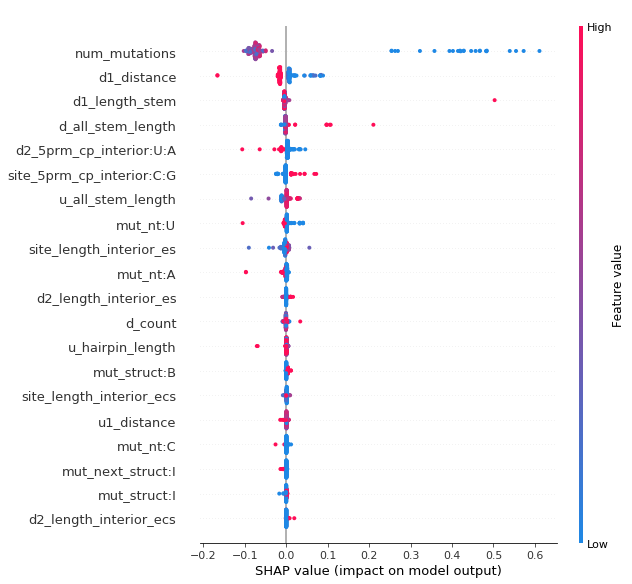

In [87]:
# summarize the effect of all the features 
shap.summary_plot(shap_values, test_X)


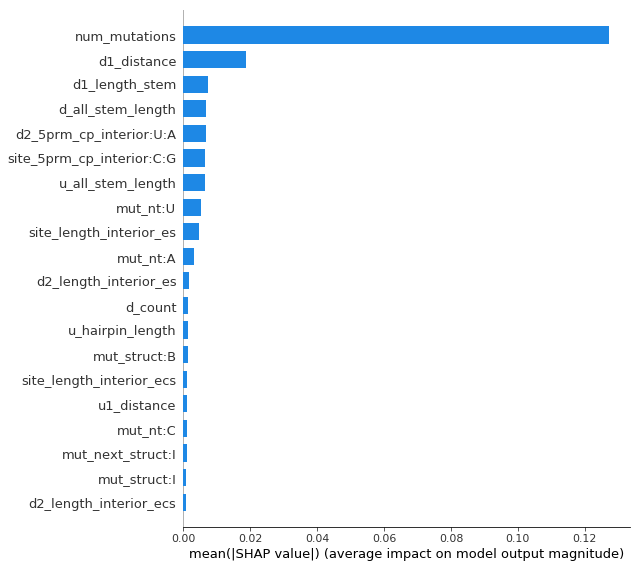

In [88]:
# We can also just take the mean absolute value of the SHAP values for each feature 
# to get a standard bar plot (produces stacked bars for multi-class outputs):
shap.summary_plot(shap_values, test_X, plot_type="bar")

In [89]:
## Compute pairwise interaction values from TreeShap
shap_interaction_values=explainer.shap_interaction_values(test_X)

In [90]:
shap_interaction_values.shape

(167, 137, 137)

In [91]:
##Average interaction values across the datapoints in the test set 
mean_interaction_values=np.mean(shap_interaction_values,axis=0)

In [92]:
Index=test_X.columns
Cols=test_X.columns
mean_interaction_values_df = pd.DataFrame(mean_interaction_values, index=Index, columns=Cols)

In [93]:
enable_plotly_in_cell()

trace = Heatmap(z=mean_interaction_values_df.values,
                   x=Cols,
                   y=Index)
tr=[trace]
iplot(tr,show_link=False)

## Degenerate Dataset: Feature Subsets<a name='2'>
<a href=#outline>Home</a>

In [94]:
shap_values=pd.DataFrame(shap_values,columns=Cols)

In [95]:
import feature_subsets 

In [96]:
print(feature_subsets.mut)
shap_contribs_subgroup(shap_values,feature_subsets.mut)

['num_mutations*', 'mut_exist*', 'mut_type*', 'mut_pos*', 'mut_site_dist*', 'mut_ref_nt*', 'mut_nt*', 'mut_struct*', 'mut_prev_struct*', 'mut_next_struct*', 'mut_same_as_site*']


0.67346853

In [97]:
print(feature_subsets.site)
shap_contribs_subgroup(shap_values,feature_subsets.site)

['site_struct*', 'site_prev_struct*', 'site_next_struct*', 'site_length_stem*', 'site_length_hairpin*', 'site_length_bulge*', 'site_length_interior_es*', 'site_length_interior_ecs*', 'site_5prm_cp_hairpin*', 'site_5prm_cp_bulge*', 'site_3prm_cp_bulge*', 'site_5prm_cp_interior*', 'site_3prm_cp_interior*']


0.07207261

In [98]:
print(feature_subsets.u)
shap_contribs_subgroup(shap_values,feature_subsets.u)

['u_count*', 'u_all_stem_length*', 'u_hairpin_length*', 'u1_exist*', 'u1_distance*', 'u1_struct*', 'u1_length_stem*', 'u1_length_hairpin*', 'u1_length_bulge*', 'u1_length_interior_es*', 'u1_length_interior_ecs*', 'u1_5prm_cp_hairpin*', 'u1_5prm_cp_bulge*', 'u1_3prm_cp_bulge*', 'u1_5prm_cp_interior*', 'u1_3prm_cp_interior*', 'u2_exist*', 'u2_distance*', 'u2_struct*', 'u2_length_stem*', 'u2_length_hairpin*', 'u2_length_bulge*', 'u2_length_interior_es*', 'u2_length_interior_ecs*', 'u2_5prm_cp_hairpin*', 'u2_5prm_cp_bulge*', 'u2_3prm_cp_bulge*', 'u2_5prm_cp_interior*', 'u2_3prm_cp_interior*', 'u3_exist*', 'u3_distance*', 'u3_struct*', 'u3_length_stem*', 'u3_length_hairpin*', 'u3_length_bulge*', 'u3_length_interior_es*', 'u3_length_interior_ecs*', 'u3_5prm_cp_hairpin*', 'u3_5prm_cp_bulge*', 'u3_3prm_cp_bulge*', 'u3_5prm_cp_interior*', 'u3_3prm_cp_interior*']


0.047494642

In [99]:
print(feature_subsets.d)
shap_contribs_subgroup(shap_values,feature_subsets.d)

['d_count*', 'd_all_stem_length*', 'd1_exist*', 'd1_distance*', 'd1_struct*', 'd1_length_stem*', 'd1_length_hairpin*', 'd1_length_bulge*', 'd1_length_interior_es*', 'd1_length_interior_ecs*', 'd1_5prm_cp_hairpin*', 'd1_5prm_cp_bulge*', 'd1_3prm_cp_bulge*', 'd1_5prm_cp_interior*', 'd1_3prm_cp_interior*', 'd2_exist*', 'd2_distance*', 'd2_struct*', 'd2_length_stem*', 'd2_length_hairpin*', 'd2_length_bulge*', 'd2_length_interior_es*', 'd2_length_interior_ecs*', 'd2_5prm_cp_hairpin*', 'd2_5prm_cp_bulge*', 'd2_3prm_cp_bulge*', 'd2_5prm_cp_interior*', 'd2_3prm_cp_interior*', 'd3_exist*', 'd3_distance*', 'd3_struct*', 'd3_length_stem*', 'd3_length_hairpin*', 'd3_length_bulge*', 'd3_length_interior_es*', 'd3_length_interior_ecs*', 'd3_5prm_cp_hairpin*', 'd3_5prm_cp_bulge*', 'd3_3prm_cp_bulge*', 'd3_5prm_cp_interior*', 'd3_3prm_cp_interior*']


0.221664

In [100]:
print(feature_subsets.u_d)
shap_contribs_subgroup(shap_values,feature_subsets.u_d)

['u_count*', 'u_all_stem_length*', 'u_hairpin_length*', 'u1_exist*', 'u1_distance*', 'u1_struct*', 'u1_length_stem*', 'u1_length_hairpin*', 'u1_length_bulge*', 'u1_length_interior_es*', 'u1_length_interior_ecs*', 'u1_5prm_cp_hairpin*', 'u1_5prm_cp_bulge*', 'u1_3prm_cp_bulge*', 'u1_5prm_cp_interior*', 'u1_3prm_cp_interior*', 'u2_exist*', 'u2_distance*', 'u2_struct*', 'u2_length_stem*', 'u2_length_hairpin*', 'u2_length_bulge*', 'u2_length_interior_es*', 'u2_length_interior_ecs*', 'u2_5prm_cp_hairpin*', 'u2_5prm_cp_bulge*', 'u2_3prm_cp_bulge*', 'u2_5prm_cp_interior*', 'u2_3prm_cp_interior*', 'u3_exist*', 'u3_distance*', 'u3_struct*', 'u3_length_stem*', 'u3_length_hairpin*', 'u3_length_bulge*', 'u3_length_interior_es*', 'u3_length_interior_ecs*', 'u3_5prm_cp_hairpin*', 'u3_5prm_cp_bulge*', 'u3_3prm_cp_bulge*', 'u3_5prm_cp_interior*', 'u3_3prm_cp_interior*', 'd_count*', 'd_all_stem_length*', 'd1_exist*', 'd1_distance*', 'd1_struct*', 'd1_length_stem*', 'd1_length_hairpin*', 'd1_length_bulge

0.26915863

In [101]:
print(feature_subsets.mut_site)
shap_contribs_subgroup(shap_values,feature_subsets.mut_site)

['num_mutations*', 'mut_exist*', 'mut_type*', 'mut_pos*', 'mut_site_dist*', 'mut_ref_nt*', 'mut_nt*', 'mut_struct*', 'mut_prev_struct*', 'mut_next_struct*', 'mut_same_as_site*', 'site_struct*', 'site_prev_struct*', 'site_next_struct*', 'site_length_stem*', 'site_length_hairpin*', 'site_length_bulge*', 'site_length_interior_es*', 'site_length_interior_ecs*', 'site_5prm_cp_hairpin*', 'site_5prm_cp_bulge*', 'site_3prm_cp_bulge*', 'site_5prm_cp_interior*', 'site_3prm_cp_interior*']


0.74554116

In [102]:
print(feature_subsets.no_up)
shap_contribs_subgroup(shap_values,feature_subsets.no_up)

['num_mutations*', 'mut_exist*', 'mut_type*', 'mut_pos*', 'mut_site_dist*', 'mut_ref_nt*', 'mut_nt*', 'mut_struct*', 'mut_prev_struct*', 'mut_next_struct*', 'mut_same_as_site*', 'site_struct*', 'site_prev_struct*', 'site_next_struct*', 'site_length_stem*', 'site_length_hairpin*', 'site_length_bulge*', 'site_length_interior_es*', 'site_length_interior_ecs*', 'site_5prm_cp_hairpin*', 'site_5prm_cp_bulge*', 'site_3prm_cp_bulge*', 'site_5prm_cp_interior*', 'site_3prm_cp_interior*', 'd_count*', 'd_all_stem_length*', 'd1_exist*', 'd1_distance*', 'd1_struct*', 'd1_length_stem*', 'd1_length_hairpin*', 'd1_length_bulge*', 'd1_length_interior_es*', 'd1_length_interior_ecs*', 'd1_5prm_cp_hairpin*', 'd1_5prm_cp_bulge*', 'd1_3prm_cp_bulge*', 'd1_5prm_cp_interior*', 'd1_3prm_cp_interior*', 'd2_exist*', 'd2_distance*', 'd2_struct*', 'd2_length_stem*', 'd2_length_hairpin*', 'd2_length_bulge*', 'd2_length_interior_es*', 'd2_length_interior_ecs*', 'd2_5prm_cp_hairpin*', 'd2_5prm_cp_bulge*', 'd2_3prm_cp_

0.96720517

In [103]:
print(feature_subsets.no_down)
shap_contribs_subgroup(shap_values,feature_subsets.no_down)

['num_mutations*', 'mut_exist*', 'mut_type*', 'mut_pos*', 'mut_site_dist*', 'mut_ref_nt*', 'mut_nt*', 'mut_struct*', 'mut_prev_struct*', 'mut_next_struct*', 'mut_same_as_site*', 'site_struct*', 'site_prev_struct*', 'site_next_struct*', 'site_length_stem*', 'site_length_hairpin*', 'site_length_bulge*', 'site_length_interior_es*', 'site_length_interior_ecs*', 'site_5prm_cp_hairpin*', 'site_5prm_cp_bulge*', 'site_3prm_cp_bulge*', 'site_5prm_cp_interior*', 'site_3prm_cp_interior*', 'u_count*', 'u_all_stem_length*', 'u_hairpin_length*', 'u1_exist*', 'u1_distance*', 'u1_struct*', 'u1_length_stem*', 'u1_length_hairpin*', 'u1_length_bulge*', 'u1_length_interior_es*', 'u1_length_interior_ecs*', 'u1_5prm_cp_hairpin*', 'u1_5prm_cp_bulge*', 'u1_3prm_cp_bulge*', 'u1_5prm_cp_interior*', 'u1_3prm_cp_interior*', 'u2_exist*', 'u2_distance*', 'u2_struct*', 'u2_length_stem*', 'u2_length_hairpin*', 'u2_length_bulge*', 'u2_length_interior_es*', 'u2_length_interior_ecs*', 'u2_5prm_cp_hairpin*', 'u2_5prm_cp_

0.7930357

In [104]:
print(feature_subsets.site_struct)
shap_contribs_subgroup(shap_values,feature_subsets.site_struct)

['site_struct', 'site_length', 'site_length_interior_es', 'site_length_interior_ecs', 'site_3prm_cp_interior']


0.06290304

In [105]:
print(feature_subsets.site_seq)
shap_contribs_subgroup(shap_values,feature_subsets.site_seq)

['site_prev_nt*', 'site_next_nt*']


0.0

In [106]:
print(feature_subsets.mut_seq)
shap_contribs_subgroup(shap_values,feature_subsets.mut_seq)

['num_mutations*', 'mut_pos*', 'mut_site_dist*', 'mut_ref_nt*', 'mut_nt*']


0.65676886

In [107]:
print(feature_subsets.mut_seq_site)
shap_contribs_subgroup(shap_values,feature_subsets.mut_seq_site)

['site_prev_nt', 'site_next_nt', 'num_mutations', 'mut_pos', 'mut_site_dist', 'mut_ref_nt, mut_nt']


0.60611254

In [108]:
print(feature_subsets.no_mut)
shap_contribs_subgroup(shap_values,feature_subsets.no_mut)

['site_struct*', 'site_prev_struct*', 'site_next_struct*', 'site_length_stem*', 'site_length_hairpin*', 'site_length_bulge*', 'site_length_interior_es*', 'site_length_interior_ecs*', 'site_5prm_cp_hairpin*', 'site_5prm_cp_bulge*', 'site_3prm_cp_bulge*', 'site_5prm_cp_interior*', 'site_3prm_cp_interior*', 'u_count*', 'u_all_stem_length*', 'u_hairpin_length*', 'u1_exist*', 'u1_distance*', 'u1_struct*', 'u1_length_stem*', 'u1_length_hairpin*', 'u1_length_bulge*', 'u1_length_interior_es*', 'u1_length_interior_ecs*', 'u1_5prm_cp_hairpin*', 'u1_5prm_cp_bulge*', 'u1_3prm_cp_bulge*', 'u1_5prm_cp_interior*', 'u1_3prm_cp_interior*', 'u2_exist*', 'u2_distance*', 'u2_struct*', 'u2_length_stem*', 'u2_length_hairpin*', 'u2_length_bulge*', 'u2_length_interior_es*', 'u2_length_interior_ecs*', 'u2_5prm_cp_hairpin*', 'u2_5prm_cp_bulge*', 'u2_3prm_cp_bulge*', 'u2_5prm_cp_interior*', 'u2_3prm_cp_interior*', 'u3_exist*', 'u3_distance*', 'u3_struct*', 'u3_length_stem*', 'u3_length_hairpin*', 'u3_length_bulg

0.34123126

## Neil1 Computational features <a name='3'>
<a href=#outline>Home</a>

In [109]:
data=pd.read_csv("../xin_feature_matrices/neil1_computational.features.csv.cleaned",header=0,sep='\t',index_col=0)

In [110]:
#remove any null editing level values 
data=data[~data["editing_value"].isnull().values]

In [111]:
data=format_for_xgboost(data)
train_split,eval_split,test_split=split_train_test_eval_by_mut_pos(data)

(407, 188)
{20: 3, 21: 3, 22: 3, 23: 4, 24: 3, 25: 4, 26: 3, 27: 4, 28: 4, 29: 4, 30: 3, 31: 4, 32: 4, 33: 4, 34: 4, 35: 4, 36: 4, 41: 20, 42: 21, 43: 18, 44: 18, 45: 20, 46: 19, 48: 20, 49: 21, 50: 21, 51: 20, 52: 20, 53: 21, 54: 19, 55: 21, 56: 20, 57: 15, 58: 31}


In [112]:
#Remove any non-varying features 
train_novar=get_singleval_features(train_split)
eval_novar=get_singleval_features(eval_split)
test_novar=get_singleval_features(test_split)
uniform_features_to_drop=list(set(train_novar+eval_novar+test_novar))

In [113]:
#Remove any null features 
train_null=get_all_null_features(train_split)
eval_null=get_all_null_features(eval_split)
test_null=get_all_null_features(test_split)
null_features_to_drop=list(set(train_null+eval_null+test_null))

In [114]:
to_drop=list(set(uniform_features_to_drop+null_features_to_drop))
print("\n".join(to_drop))

d2_3prm_cp_bulge:U:A
u3_5prm_cp_interior
d3_3prm_cp_bulge:C:G
site_3prm_cp_interior:U:A
mut_prev_struct:B
u3_5prm_cp_bulge:U:G
site_5prm_cp_bulge:C:G
d2_3prm_cp_bulge:U:G
d1_length_interior_ecs
d1_struct:S
site_next_struct:I
d3_length_hairpin
d2_exist
u1_5prm_cp_hairpin:C:G
site_5prm_cp_bulge:G:U
u1_5prm_cp_interior
d2_5prm_cp_hairpin:C:G
mut_struct:B
u2_5prm_cp_bulge:G:U
d2_struct:H
u2_length_interior_ecs
site_3prm_cp_bulge:G:C
d1_length_interior_es
site_3prm_cp_bulge:A:U
d2_length_hairpin
d2_struct:S
d2_3prm_cp_interior:G:U
site_5prm_cp_interior:U:G
d2_5prm_cp_bulge:G:U
d1_exist
u3_3prm_cp_interior
u1_length_interior_ecs
u2_3prm_cp_interior
d3_struct:I
d1_5prm_cp_interior:U:A
site_5prm_cp_interior:A:U
d1_3prm_cp_interior:G:C
u2_5prm_cp_bulge:U:A
d1_5prm_cp_bulge
u3_length_interior_ecs
u2_length_interior_es
u1_3prm_cp_interior
site_5prm_cp_bulge:A:U
u2_3prm_cp_bulge:G:U
u1_length_hairpin
u2_5prm_cp_hairpin:U:A
mut_prev_struct:M
u1_struct:H
d1_5prm_cp_interior:U:G
d2_5prm_cp_interior:G

In [115]:
train_split=train_split.drop(to_drop,axis=1)
eval_split=eval_split.drop(to_drop,axis=1)
test_split=test_split.drop(to_drop,axis=1)

In [116]:
train_y=train_split['editing_value']
train_X=train_split.drop(['editing_value'],axis=1)

eval_y=eval_split['editing_value']
eval_X=eval_split.drop(['editing_value'],axis=1)

test_y=test_split['editing_value']
test_X=test_split.drop(['editing_value'],axis=1)

In [117]:
print(train_X.shape)
print(train_y.shape)
print(eval_X.shape)
print(eval_y.shape)
print(test_X.shape)
print(test_y.shape)


(267, 90)
(267,)
(49, 90)
(49,)
(75, 90)
(75,)


In [118]:
## format matrixes for xgboost 
dtrain=xgboost.DMatrix(train_X,train_y)
deval=xgboost.DMatrix(eval_X,eval_y)
dtest=xgboost.DMatrix(test_X,test_y)

In [119]:
## set model training parameters 
param=dict() 
param['nthread'] = 20
#rmse -- root mean square error 
# mae -- mean absolute error 
# map -- mean average precision 
# auc -- area under ROC curve 
# aucpr -- area under precision recall curve 
param['eval_metric'] = ['auc','mae','map','aucpr','rmse']

In [120]:
evallist = [(deval, 'eval'), (dtrain, 'train')]


In [121]:
num_round = 1000
bst = xgboost.train(param, dtrain, num_round, evallist,early_stopping_rounds=10)

[18:15:39] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=6
[0]	eval-auc:0.813327	eval-mae:0.2494	eval-map:1	eval-aucpr:0.480394	eval-rmse:0.275678	train-auc:0.800693	train-mae:0.217216	train-map:1	train-aucpr:0.531151	train-rmse:0.251162
Multiple eval metrics have been passed: 'train-rmse' will be used for early stopping.

Will train until train-rmse hasn't improved in 10 rounds.
[18:15:39] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=6
[1]	eval-auc:0.802242	eval-mae:0.189713	eval-map:1	eval-aucpr:0.416409	eval-rmse:0.207376	train-auc:0.815181	train-mae:0.164527	train-map:1	train-aucpr:0.553923	train-rmse:0.189143
[18:15:39] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=6
[2]	eval-auc:0.804207	eval-mae:0.143342	eval-map:1	eval-aucpr:0.426489	eval-rmse:0.159588	train-auc:0.820828	train-mae:0.12669

[18:15:39] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=6
[27]	eval-auc:0.821318	eval-mae:0.060316	eval-map:1	eval-aucpr:0.48646	eval-rmse:0.097576	train-auc:0.839632	train-mae:0.022208	train-map:1	train-aucpr:0.587919	train-rmse:0.041487
[18:15:39] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=6
[28]	eval-auc:0.821639	eval-mae:0.060433	eval-map:1	eval-aucpr:0.487709	eval-rmse:0.097626	train-auc:0.839707	train-mae:0.021792	train-map:1	train-aucpr:0.58803	train-rmse:0.041043
[18:15:39] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=6
[29]	eval-auc:0.821398	eval-mae:0.06037	eval-map:1	eval-aucpr:0.486548	eval-rmse:0.097426	train-auc:0.839762	train-mae:0.02154	train-map:1	train-aucpr:0.588116	train-rmse:0.040705
[18:15:39] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra n

[18:15:39] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=6
[54]	eval-auc:0.820756	eval-mae:0.060912	eval-map:1	eval-aucpr:0.489719	eval-rmse:0.09717	train-auc:0.840622	train-mae:0.015659	train-map:1	train-aucpr:0.589429	train-rmse:0.036875
[18:15:39] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=6
[55]	eval-auc:0.821077	eval-mae:0.060919	eval-map:1	eval-aucpr:0.489801	eval-rmse:0.097195	train-auc:0.840643	train-mae:0.015517	train-map:1	train-aucpr:0.589476	train-rmse:0.036795
[18:15:39] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=6
[56]	eval-auc:0.821077	eval-mae:0.060924	eval-map:1	eval-aucpr:0.489801	eval-rmse:0.097173	train-auc:0.840653	train-mae:0.015393	train-map:1	train-aucpr:0.589495	train-rmse:0.036754
[18:15:39] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extr

[18:15:39] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=6
[81]	eval-auc:0.821291	eval-mae:0.060914	eval-map:1	eval-aucpr:0.489886	eval-rmse:0.096502	train-auc:0.840869	train-mae:0.013159	train-map:1	train-aucpr:0.589846	train-rmse:0.035749
[18:15:39] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=6
[82]	eval-auc:0.821291	eval-mae:0.060863	eval-map:1	eval-aucpr:0.489886	eval-rmse:0.096336	train-auc:0.840869	train-mae:0.013096	train-map:1	train-aucpr:0.589817	train-rmse:0.035735
[18:15:39] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=6
[83]	eval-auc:0.820863	eval-mae:0.060867	eval-map:1	eval-aucpr:0.489746	eval-rmse:0.096336	train-auc:0.840871	train-mae:0.013065	train-map:1	train-aucpr:0.589818	train-rmse:0.03573
[18:15:39] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extr

[18:15:39] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[108]	eval-auc:0.820515	eval-mae:0.061015	eval-map:1	eval-aucpr:0.489624	eval-rmse:0.096177	train-auc:0.840913	train-mae:0.012203	train-map:1	train-aucpr:0.589883	train-rmse:0.035553
[18:15:39] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[109]	eval-auc:0.820515	eval-mae:0.061015	eval-map:1	eval-aucpr:0.489624	eval-rmse:0.096177	train-auc:0.840913	train-mae:0.012203	train-map:1	train-aucpr:0.589883	train-rmse:0.035553
[18:15:39] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[110]	eval-auc:0.820515	eval-mae:0.061015	eval-map:1	eval-aucpr:0.489624	eval-rmse:0.096177	train-auc:0.840913	train-mae:0.012203	train-map:1	train-aucpr:0.589883	train-rmse:0.035553
[18:15:39] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extr

In [122]:
# save to binary file for faster loading
bst.save_model('neil1.computational.model')
# save model to text file 
bst.dump_model('neil1.computational.raw.txt')


In [123]:
## get model predictions on the test split 
test_pred = bst.predict(dtest)

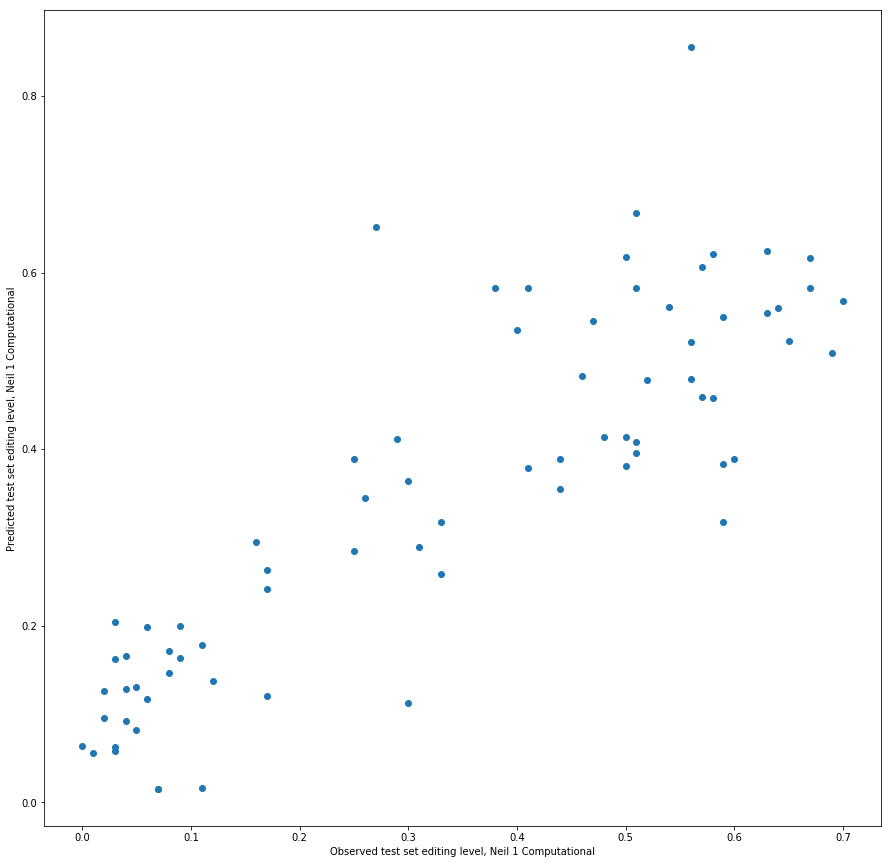

In [124]:
matplotlib.rcParams['figure.figsize'] = [15, 15]
test_y=list(test_y)
test_pred=list(test_pred)
#fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(test_y,test_pred,'o')
plt.xlabel("Observed test set editing level, Neil 1 Computational")
plt.ylabel("Predicted test set editing level, Neil 1 Computational")
plt.show()

In [125]:
# explain the model's predictions using SHAP values
explainer = shap.TreeExplainer(bst)
shap_values = explainer.shap_values(test_X)


In [126]:
shap_values.shape

(75, 90)

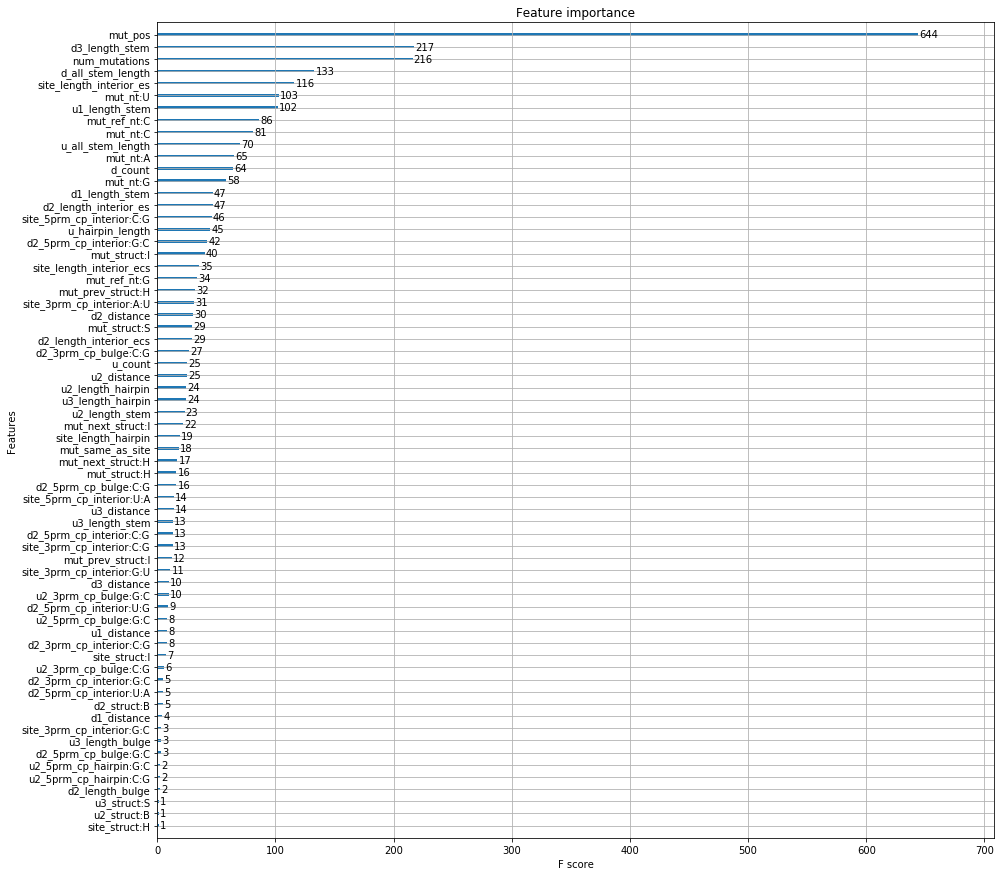

In [127]:
xgboost.plot_importance(bst)

In [128]:
# visualize prediction for isoform with highest editing level 
max_index=test_y.index(max(test_y))
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[max_index,:], test_X.iloc[max_index,:])

In [129]:
# visualize prediction for the isoform with the lowest editing level 
min_index=test_y.index(min(test_y))
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[min_index,:], test_X.iloc[min_index,:])

In [130]:
# visualize the training set predictions
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values,train_X)

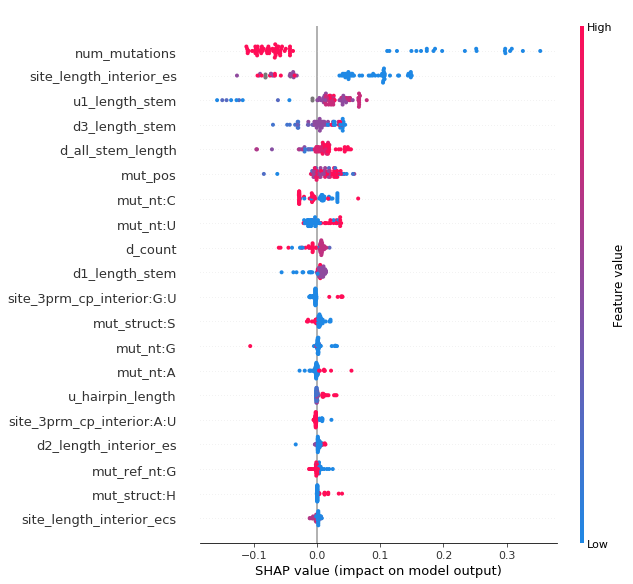

In [131]:
# summarize the effect of all the features 
shap.initjs()
shap.summary_plot(shap_values, test_X)


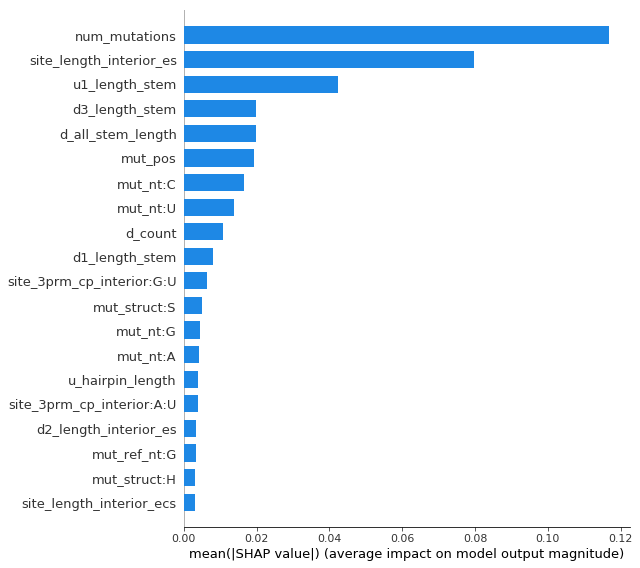

In [132]:
# We can also just take the mean absolute value of the SHAP values for each feature 
# to get a standard bar plot (produces stacked bars for multi-class outputs):
shap.summary_plot(shap_values, test_X, plot_type="bar")

In [133]:
## Compute pairwise interaction values from TreeShap
shap_interaction_values=explainer.shap_interaction_values(test_X)

In [134]:
shap_interaction_values.shape

(75, 90, 90)

In [135]:
##Average interaction values across the datapoints in the test set 
mean_interaction_values=np.mean(shap_interaction_values,axis=0)

In [136]:
Index=test_X.columns
Cols=test_X.columns
mean_interaction_values_df = pd.DataFrame(mean_interaction_values, index=Index, columns=Cols)

In [137]:
enable_plotly_in_cell()

trace = Heatmap(z=mean_interaction_values_df.values,
                   x=Cols,
                   y=Index)
tr=[trace]
iplot(tr,show_link=False)

## Computational Dataset: Feature Subsets<a name='4'>
<a href=#outline>Home</a>

In [138]:
shap_values=pd.DataFrame(shap_values,columns=Cols)

In [139]:
import feature_subsets 

In [140]:
print(feature_subsets.mut)
shap_contribs_subgroup(shap_values,feature_subsets.mut)

['num_mutations*', 'mut_exist*', 'mut_type*', 'mut_pos*', 'mut_site_dist*', 'mut_ref_nt*', 'mut_nt*', 'mut_struct*', 'mut_prev_struct*', 'mut_next_struct*', 'mut_same_as_site*']


0.4646204

In [141]:
print(feature_subsets.site)
shap_contribs_subgroup(shap_values,feature_subsets.site)

['site_struct*', 'site_prev_struct*', 'site_next_struct*', 'site_length_stem*', 'site_length_hairpin*', 'site_length_bulge*', 'site_length_interior_es*', 'site_length_interior_ecs*', 'site_5prm_cp_hairpin*', 'site_5prm_cp_bulge*', 'site_3prm_cp_bulge*', 'site_5prm_cp_interior*', 'site_3prm_cp_interior*']


0.23472567

In [142]:
print(feature_subsets.u)
shap_contribs_subgroup(shap_values,feature_subsets.u)

['u_count*', 'u_all_stem_length*', 'u_hairpin_length*', 'u1_exist*', 'u1_distance*', 'u1_struct*', 'u1_length_stem*', 'u1_length_hairpin*', 'u1_length_bulge*', 'u1_length_interior_es*', 'u1_length_interior_ecs*', 'u1_5prm_cp_hairpin*', 'u1_5prm_cp_bulge*', 'u1_3prm_cp_bulge*', 'u1_5prm_cp_interior*', 'u1_3prm_cp_interior*', 'u2_exist*', 'u2_distance*', 'u2_struct*', 'u2_length_stem*', 'u2_length_hairpin*', 'u2_length_bulge*', 'u2_length_interior_es*', 'u2_length_interior_ecs*', 'u2_5prm_cp_hairpin*', 'u2_5prm_cp_bulge*', 'u2_3prm_cp_bulge*', 'u2_5prm_cp_interior*', 'u2_3prm_cp_interior*', 'u3_exist*', 'u3_distance*', 'u3_struct*', 'u3_length_stem*', 'u3_length_hairpin*', 'u3_length_bulge*', 'u3_length_interior_es*', 'u3_length_interior_ecs*', 'u3_5prm_cp_hairpin*', 'u3_5prm_cp_bulge*', 'u3_3prm_cp_bulge*', 'u3_5prm_cp_interior*', 'u3_3prm_cp_interior*']


0.13203746

In [143]:
print(feature_subsets.d)
shap_contribs_subgroup(shap_values,feature_subsets.d)

['d_count*', 'd_all_stem_length*', 'd1_exist*', 'd1_distance*', 'd1_struct*', 'd1_length_stem*', 'd1_length_hairpin*', 'd1_length_bulge*', 'd1_length_interior_es*', 'd1_length_interior_ecs*', 'd1_5prm_cp_hairpin*', 'd1_5prm_cp_bulge*', 'd1_3prm_cp_bulge*', 'd1_5prm_cp_interior*', 'd1_3prm_cp_interior*', 'd2_exist*', 'd2_distance*', 'd2_struct*', 'd2_length_stem*', 'd2_length_hairpin*', 'd2_length_bulge*', 'd2_length_interior_es*', 'd2_length_interior_ecs*', 'd2_5prm_cp_hairpin*', 'd2_5prm_cp_bulge*', 'd2_3prm_cp_bulge*', 'd2_5prm_cp_interior*', 'd2_3prm_cp_interior*', 'd3_exist*', 'd3_distance*', 'd3_struct*', 'd3_length_stem*', 'd3_length_hairpin*', 'd3_length_bulge*', 'd3_length_interior_es*', 'd3_length_interior_ecs*', 'd3_5prm_cp_hairpin*', 'd3_5prm_cp_bulge*', 'd3_3prm_cp_bulge*', 'd3_5prm_cp_interior*', 'd3_3prm_cp_interior*']


0.1864432

In [144]:
print(feature_subsets.u_d)
shap_contribs_subgroup(shap_values,feature_subsets.u_d)

['u_count*', 'u_all_stem_length*', 'u_hairpin_length*', 'u1_exist*', 'u1_distance*', 'u1_struct*', 'u1_length_stem*', 'u1_length_hairpin*', 'u1_length_bulge*', 'u1_length_interior_es*', 'u1_length_interior_ecs*', 'u1_5prm_cp_hairpin*', 'u1_5prm_cp_bulge*', 'u1_3prm_cp_bulge*', 'u1_5prm_cp_interior*', 'u1_3prm_cp_interior*', 'u2_exist*', 'u2_distance*', 'u2_struct*', 'u2_length_stem*', 'u2_length_hairpin*', 'u2_length_bulge*', 'u2_length_interior_es*', 'u2_length_interior_ecs*', 'u2_5prm_cp_hairpin*', 'u2_5prm_cp_bulge*', 'u2_3prm_cp_bulge*', 'u2_5prm_cp_interior*', 'u2_3prm_cp_interior*', 'u3_exist*', 'u3_distance*', 'u3_struct*', 'u3_length_stem*', 'u3_length_hairpin*', 'u3_length_bulge*', 'u3_length_interior_es*', 'u3_length_interior_ecs*', 'u3_5prm_cp_hairpin*', 'u3_5prm_cp_bulge*', 'u3_3prm_cp_bulge*', 'u3_5prm_cp_interior*', 'u3_3prm_cp_interior*', 'd_count*', 'd_all_stem_length*', 'd1_exist*', 'd1_distance*', 'd1_struct*', 'd1_length_stem*', 'd1_length_hairpin*', 'd1_length_bulge

0.31848067

In [145]:
print(feature_subsets.mut_site)
shap_contribs_subgroup(shap_values,feature_subsets.mut_site)

['num_mutations*', 'mut_exist*', 'mut_type*', 'mut_pos*', 'mut_site_dist*', 'mut_ref_nt*', 'mut_nt*', 'mut_struct*', 'mut_prev_struct*', 'mut_next_struct*', 'mut_same_as_site*', 'site_struct*', 'site_prev_struct*', 'site_next_struct*', 'site_length_stem*', 'site_length_hairpin*', 'site_length_bulge*', 'site_length_interior_es*', 'site_length_interior_ecs*', 'site_5prm_cp_hairpin*', 'site_5prm_cp_bulge*', 'site_3prm_cp_bulge*', 'site_5prm_cp_interior*', 'site_3prm_cp_interior*']


0.6993461

In [146]:
print(feature_subsets.no_up)
shap_contribs_subgroup(shap_values,feature_subsets.no_up)

['num_mutations*', 'mut_exist*', 'mut_type*', 'mut_pos*', 'mut_site_dist*', 'mut_ref_nt*', 'mut_nt*', 'mut_struct*', 'mut_prev_struct*', 'mut_next_struct*', 'mut_same_as_site*', 'site_struct*', 'site_prev_struct*', 'site_next_struct*', 'site_length_stem*', 'site_length_hairpin*', 'site_length_bulge*', 'site_length_interior_es*', 'site_length_interior_ecs*', 'site_5prm_cp_hairpin*', 'site_5prm_cp_bulge*', 'site_3prm_cp_bulge*', 'site_5prm_cp_interior*', 'site_3prm_cp_interior*', 'd_count*', 'd_all_stem_length*', 'd1_exist*', 'd1_distance*', 'd1_struct*', 'd1_length_stem*', 'd1_length_hairpin*', 'd1_length_bulge*', 'd1_length_interior_es*', 'd1_length_interior_ecs*', 'd1_5prm_cp_hairpin*', 'd1_5prm_cp_bulge*', 'd1_3prm_cp_bulge*', 'd1_5prm_cp_interior*', 'd1_3prm_cp_interior*', 'd2_exist*', 'd2_distance*', 'd2_struct*', 'd2_length_stem*', 'd2_length_hairpin*', 'd2_length_bulge*', 'd2_length_interior_es*', 'd2_length_interior_ecs*', 'd2_5prm_cp_hairpin*', 'd2_5prm_cp_bulge*', 'd2_3prm_cp_

0.8857892

In [147]:
print(feature_subsets.no_down)
shap_contribs_subgroup(shap_values,feature_subsets.no_down)

['num_mutations*', 'mut_exist*', 'mut_type*', 'mut_pos*', 'mut_site_dist*', 'mut_ref_nt*', 'mut_nt*', 'mut_struct*', 'mut_prev_struct*', 'mut_next_struct*', 'mut_same_as_site*', 'site_struct*', 'site_prev_struct*', 'site_next_struct*', 'site_length_stem*', 'site_length_hairpin*', 'site_length_bulge*', 'site_length_interior_es*', 'site_length_interior_ecs*', 'site_5prm_cp_hairpin*', 'site_5prm_cp_bulge*', 'site_3prm_cp_bulge*', 'site_5prm_cp_interior*', 'site_3prm_cp_interior*', 'u_count*', 'u_all_stem_length*', 'u_hairpin_length*', 'u1_exist*', 'u1_distance*', 'u1_struct*', 'u1_length_stem*', 'u1_length_hairpin*', 'u1_length_bulge*', 'u1_length_interior_es*', 'u1_length_interior_ecs*', 'u1_5prm_cp_hairpin*', 'u1_5prm_cp_bulge*', 'u1_3prm_cp_bulge*', 'u1_5prm_cp_interior*', 'u1_3prm_cp_interior*', 'u2_exist*', 'u2_distance*', 'u2_struct*', 'u2_length_stem*', 'u2_length_hairpin*', 'u2_length_bulge*', 'u2_length_interior_es*', 'u2_length_interior_ecs*', 'u2_5prm_cp_hairpin*', 'u2_5prm_cp_

0.8313836

In [148]:
print(feature_subsets.site_struct)
shap_contribs_subgroup(shap_values,feature_subsets.site_struct)

['site_struct', 'site_length', 'site_length_interior_es', 'site_length_interior_ecs', 'site_3prm_cp_interior']


0.41255367

In [149]:
print(feature_subsets.site_seq)
shap_contribs_subgroup(shap_values,feature_subsets.site_seq)

['site_prev_nt*', 'site_next_nt*']


0.0

In [150]:
print(feature_subsets.mut_seq)
shap_contribs_subgroup(shap_values,feature_subsets.mut_seq)

['num_mutations*', 'mut_pos*', 'mut_site_dist*', 'mut_ref_nt*', 'mut_nt*']


0.42451245

In [151]:
print(feature_subsets.mut_seq_site)
shap_contribs_subgroup(shap_values,feature_subsets.mut_seq_site)

['site_prev_nt', 'site_next_nt', 'num_mutations', 'mut_pos', 'mut_site_dist', 'mut_ref_nt, mut_nt']


0.31423283

In [152]:
print(feature_subsets.no_mut)
shap_contribs_subgroup(shap_values,feature_subsets.no_mut)

['site_struct*', 'site_prev_struct*', 'site_next_struct*', 'site_length_stem*', 'site_length_hairpin*', 'site_length_bulge*', 'site_length_interior_es*', 'site_length_interior_ecs*', 'site_5prm_cp_hairpin*', 'site_5prm_cp_bulge*', 'site_3prm_cp_bulge*', 'site_5prm_cp_interior*', 'site_3prm_cp_interior*', 'u_count*', 'u_all_stem_length*', 'u_hairpin_length*', 'u1_exist*', 'u1_distance*', 'u1_struct*', 'u1_length_stem*', 'u1_length_hairpin*', 'u1_length_bulge*', 'u1_length_interior_es*', 'u1_length_interior_ecs*', 'u1_5prm_cp_hairpin*', 'u1_5prm_cp_bulge*', 'u1_3prm_cp_bulge*', 'u1_5prm_cp_interior*', 'u1_3prm_cp_interior*', 'u2_exist*', 'u2_distance*', 'u2_struct*', 'u2_length_stem*', 'u2_length_hairpin*', 'u2_length_bulge*', 'u2_length_interior_es*', 'u2_length_interior_ecs*', 'u2_5prm_cp_hairpin*', 'u2_5prm_cp_bulge*', 'u2_3prm_cp_bulge*', 'u2_5prm_cp_interior*', 'u2_3prm_cp_interior*', 'u3_exist*', 'u3_distance*', 'u3_struct*', 'u3_length_stem*', 'u3_length_hairpin*', 'u3_length_bulg

0.5532063